In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.drive_and_act_keypoint_dataset import DriveAndActKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path

pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/drive_and_act/')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/drive_and_act/prediction/linear_model_all_actors'


train_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    # actors=['vp1', 'vp4', 'vp5', 'vp6', 'vp7', 'vp8', 'vp9', 'vp10', 'vp15'],
    actors=['vp1', 'vp2', 'vp3', 'vp4', 'vp5', 'vp6', 'vp7', 'vp8'],
    exclude_ankle=True,
    exclude_knee=True
)
val_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    # actors=['vp2', 'vp3'],
    actors=['vp9', 'vp10', 'vp15'],
    exclude_ankle=True,
    exclude_knee=True
)
test_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    actors=['vp11', 'vp12', 'vp13', 'vp14'],
    # actors=['vp13', 'vp14', 'vp15'],
    exclude_ankle=True,
    exclude_knee=True
)
all_activities = train_dataset.activities.union(val_dataset.activities).union(test_dataset.activities)
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_knee=True, all_activities=all_activities, is_silence=False)
print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)


model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)

if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234


skipping problematic image 15783
skipping problematic image 17258
skipping problematic image 17259
skipping problematic image 21271
skipping problematic image 21272
skipping problematic image 21273
skipping problematic image 21274
skipping problematic image 21275
skipping problematic image 21276
skipping problematic image 33527


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_dataset 22885 val_dataset 6240 test_dataset 11018


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 2767.831563949585


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 1785 batches: 536.9940378961443
val MPJPE from: 6208 samples : 95.31998634338379


Validation: 0it [00:00, ?it/s]

check #2
training loss from 1785 batches: 111.73963890690096
val MPJPE from: 6208 samples : 76.2622058391571


Validation: 0it [00:00, ?it/s]

check #3
training loss from 1785 batches: 93.25642310688141
val MPJPE from: 6208 samples : 71.59721106290817


Validation: 0it [00:00, ?it/s]

check #4
training loss from 1785 batches: 85.0924919132425
val MPJPE from: 6208 samples : 78.90073210000992


Validation: 0it [00:00, ?it/s]

check #5
training loss from 1785 batches: 80.57032611106291
val MPJPE from: 6208 samples : 82.74684101343155


Validation: 0it [00:00, ?it/s]

check #6
training loss from 1785 batches: 77.53204990084433
val MPJPE from: 6208 samples : 68.741574883461


Validation: 0it [00:00, ?it/s]

check #7
training loss from 1785 batches: 75.22539382889157
val MPJPE from: 6208 samples : 73.05120676755905


Validation: 0it [00:00, ?it/s]

check #8
training loss from 1785 batches: 73.39065792847748
val MPJPE from: 6208 samples : 82.61590451002121


Validation: 0it [00:00, ?it/s]

check #9
training loss from 1785 batches: 71.85154149637503
val MPJPE from: 6208 samples : 85.13591438531876


Validation: 0it [00:00, ?it/s]

check #10
training loss from 1785 batches: 70.79202008305812
val MPJPE from: 6208 samples : 68.01722943782806


Validation: 0it [00:00, ?it/s]

check #11
training loss from 1785 batches: 69.76351768654935
val MPJPE from: 6208 samples : 68.97401064634323


Validation: 0it [00:00, ?it/s]

check #12
training loss from 1785 batches: 69.13370398246273
val MPJPE from: 6208 samples : 68.64751130342484


Validation: 0it [00:00, ?it/s]

check #13
training loss from 1785 batches: 68.39553957142417
val MPJPE from: 6208 samples : 70.47686725854874


Validation: 0it [00:00, ?it/s]

check #14
training loss from 1785 batches: 68.14056852576779
val MPJPE from: 6208 samples : 68.48900020122528


Validation: 0it [00:00, ?it/s]

check #15
training loss from 1785 batches: 67.72138605556901
val MPJPE from: 6208 samples : 68.6308965086937


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/drive_and_act/prediction/linear_model_all_actors/lightning_logs/version_1/checkpoints/epoch=49-step=17850.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/drive_and_act/prediction/linear_model_all_actors/lightning_logs/version_1/checkpoints/epoch=49-step=17850.ckpt
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 

Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


MPJPE: 60.255107235941715
PJPE
                      PJPE
nose             52.240593
left_eye         52.340491
right_eye        49.825757
left_ear         15.851839
right_ear        42.654039
left_shoulder    42.002946
right_shoulder   41.137806
left_elbow       66.521069
right_elbow      68.153112
left_wrist       81.170716
right_wrist     100.579533
left_hip         37.280116
right_hip        37.257442
activities_mpjpe:
{'sitting_still': 48.912091378526256, 'entering_car': 121.06569942931425, 'closing_door_inside': 88.99462952854854, 'fetching_an_object': 104.22771616411718, 'closing_bottle': 54.585224345387616, 'pressing_automation_button': 59.756788438673546, 'opening_bottle': 62.495899518455694, 'drinking': 52.54555862292021, 'preparing_food': 68.7791357832132, 'eating': 51.60659920684962, 'opening_backpack': 111.57053673075856, 'placing_an_object': 95.43891286086792, 'reading_newspaper': 68.11796505894434, 'taking_off_sunglasses': 73.14464375245521, 'writing': 63.30883071904769,

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │    60.255107235941715     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 60.255107235941715}]

In [3]:
pd.DataFrame(lit_model.test_history[0]['activities_mpjpe'], index=['mpjpe']).T.sort_values('mpjpe')

,mpjpe
sitting_still,48.912091
eating,51.606599
working_on_laptop,51.879586
interacting_with_phone,51.905474
drinking,52.545559
closing_bottle,54.585224
pressing_automation_button,59.756788
reading_magazine,60.413483
opening_bottle,62.495900
writing,63.308831


In [4]:
pd.DataFrame(lit_model.test_history[0]['activities_mpjpe'], index=['mpjpe']).T.mean()

mpjpe    82.101528
dtype: float64

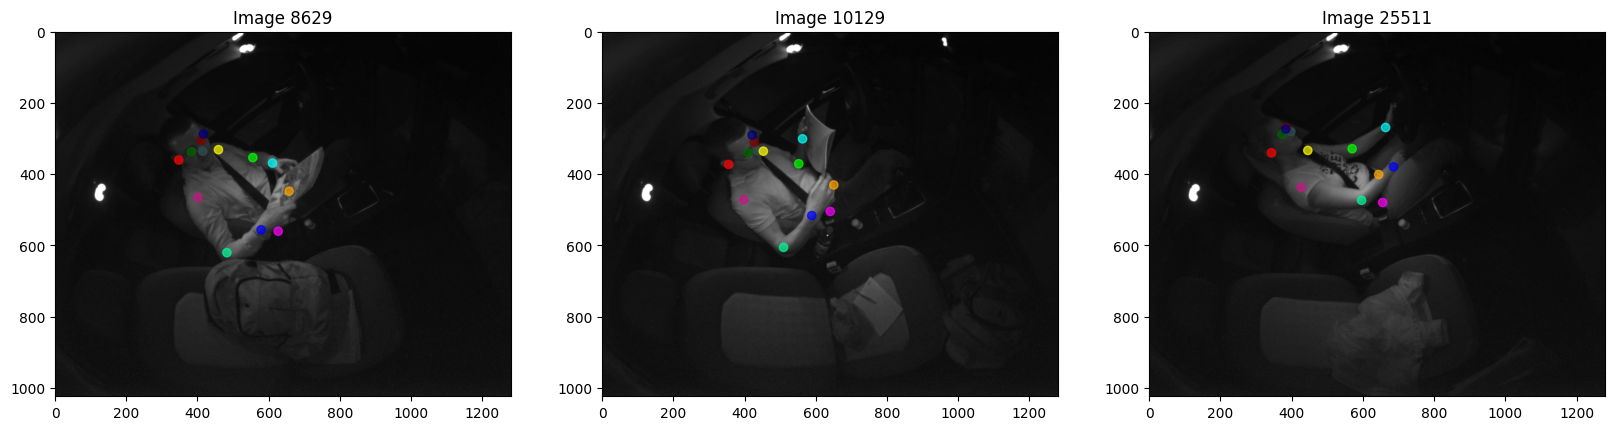

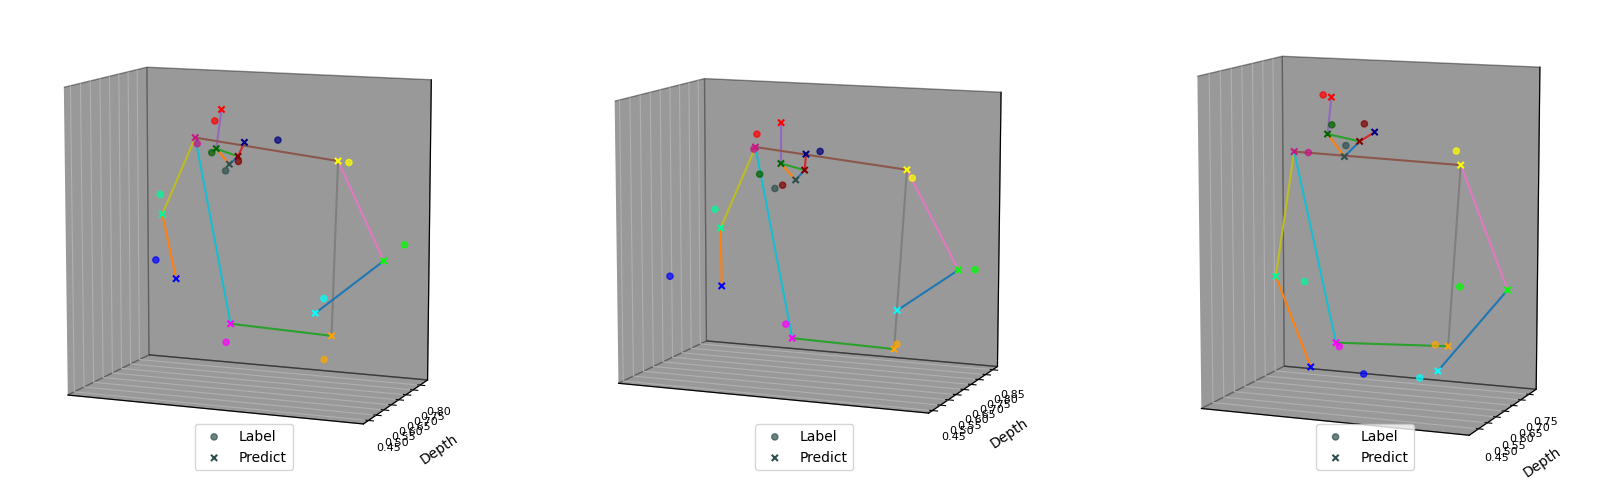

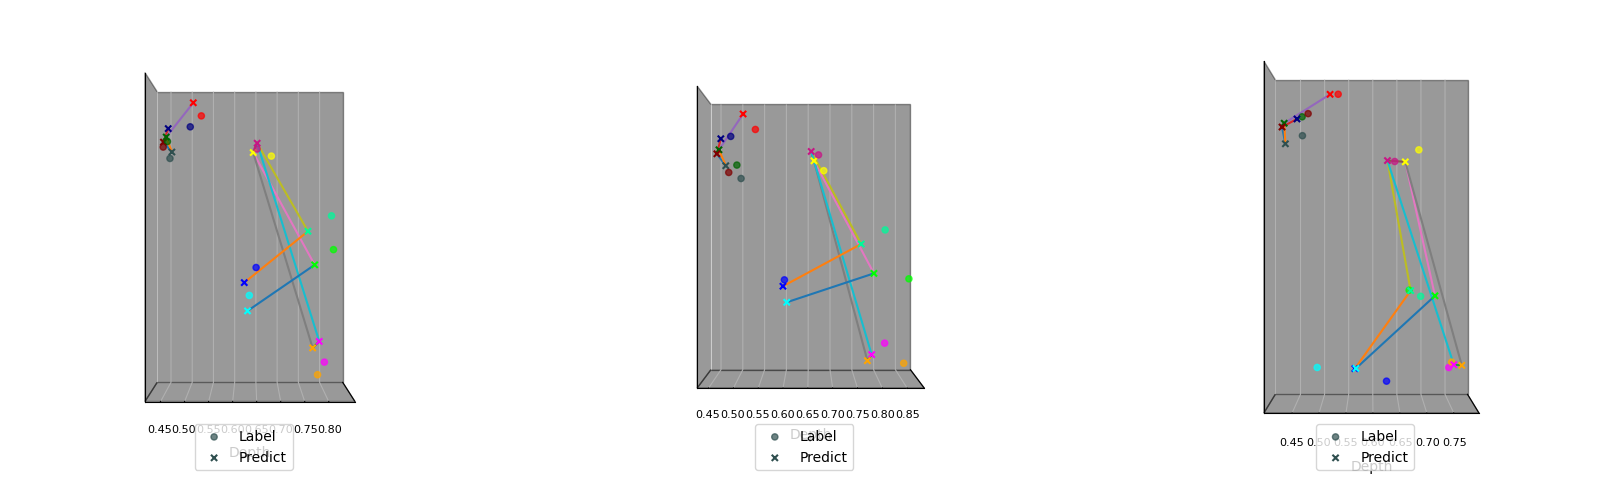

In [5]:
plot_samples(
    dataset_root_path,
    trainer.model,
    test_loader,
    'train',
    img_figsize=(20, 10),
    img_width=image_width,
    img_height=image_height,
    plot_figsize=(20.5, 10),
    sample_idices=[1000, 2500, 6000],
    is_plot_gt_skeleton=False
)